In [91]:
import matplotlib.pyplot as plt
from stompy import utils
import xarray as xr
import pandas as pd

import stompy.model.schism.schism_model as sch
import peschism
import numpy as np
import os
%matplotlib notebook

In [102]:
run_dirs=['data_schmouth_v024']

In [103]:
run_dir=run_dirs[0]
model=peschism.PescaSchism.load(run_dir)

INFO:HydroModel:Resampling leads to 295 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 204 points for thalweg_butano


Setting seepage


In [104]:
ms=model.map_output(1)

<IPython.core.display.Javascript object>


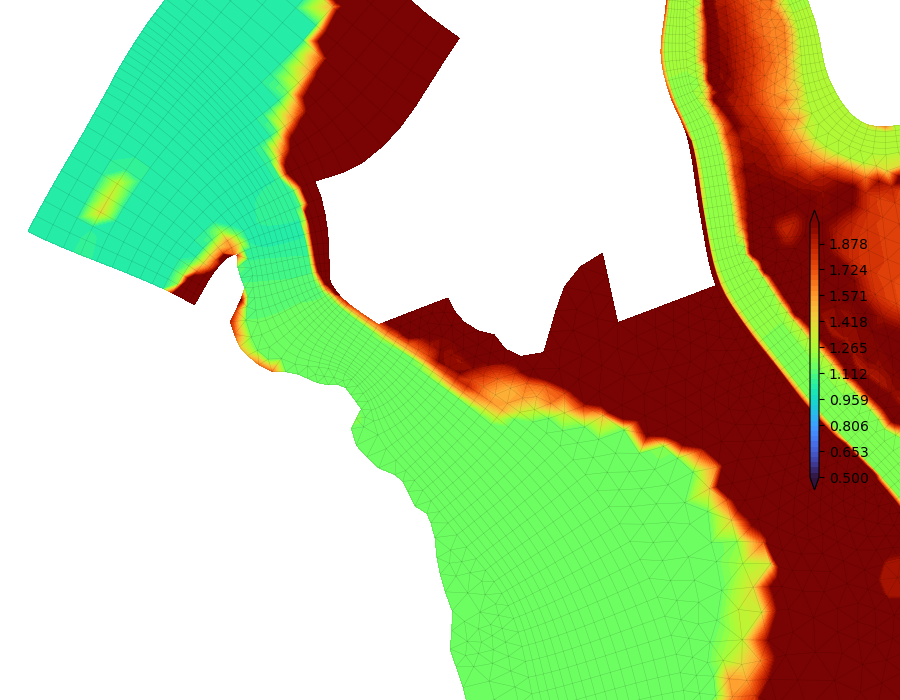

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [108]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(ms.elev.isel(time=26).values,
                                  np.linspace(0.5,2.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

<IPython.core.display.Javascript object>


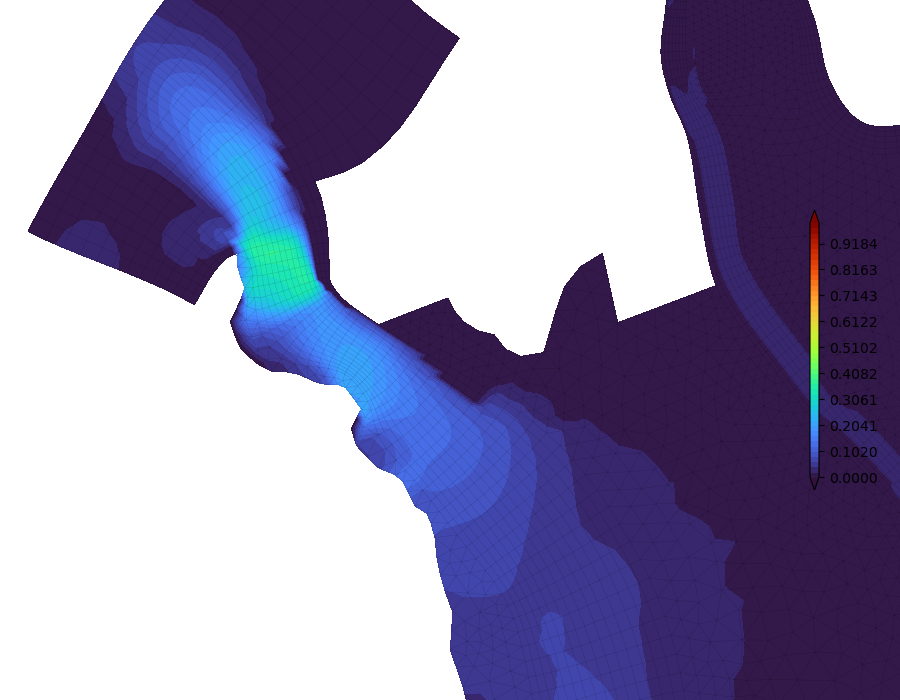

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [109]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
speed=utils.mag(ms.dahv.isel(time=9).values)
cset=ms.grid.contourf_node_values(speed,
                                  np.linspace(0.0,1.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

<IPython.core.display.Javascript object>


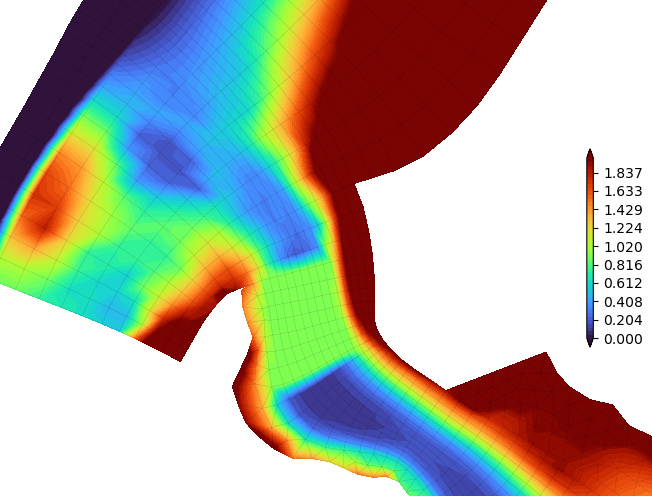

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [116]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
ti=9

dry=ms['wetdry_node'].isel(time=ti).values==1
z_bed=ms['zcor'].isel(time=9,nSCHISM_vgrid_layers=0).values
z_bed=np.where(dry,ms.grid.nodes['node_z_bed'],z_bed)
cset=ms.grid.contourf_node_values(z_bed,
                                  np.linspace(0.0,2.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))


<IPython.core.display.Javascript object>


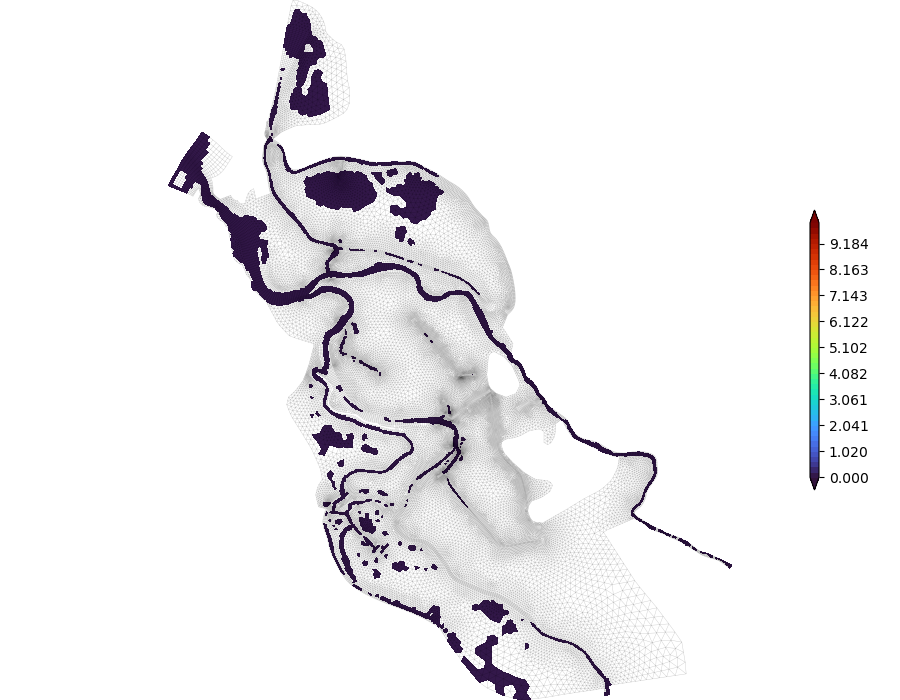

In [10]:
# Surface salinity:
fig,ax=plt.subplots(figsize=(9,7))

ti=-1
ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
wet_cell=ms.wetdry_elem.isel(time=ti).values<0.5

#data=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values

s_top=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values
s_bed=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=0).values
data=s_bed-s_top

cset=ms.grid.contourf_node_values(data,
                                  np.linspace(0,10,50),
                                  tri_kwargs=dict(cell_mask=wet_cell),
                                  extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

In [111]:
ds=model.station_output()
qcm=model.prep_qcm_data()
sub_qcm=qcm.isel(time=(qcm.time>=ds.time.values[0])&(qcm.time<=ds.time.values[-1]))

In [112]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"
# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')

<IPython.core.display.Javascript object>


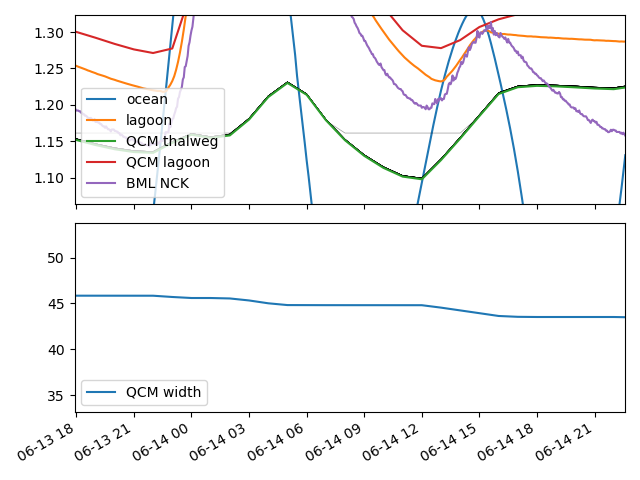

In [118]:
# Find a spot in the lagoon, and a spot near the ocean
xy_ocean=[552041.12, 4124763.48]
xy_lagoon=[552277.89, 4124400.70]

sta_ocean=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_ocean))
sta_lagoon=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_lagoon))

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(ds.time,ds['elev'].isel(station=sta_ocean),label='ocean')
axs[0].plot(ds.time,ds['elev'].isel(station=sta_lagoon),label='lagoon')

morph_nodes=[model.grid.cell_to_nodes(c) for c in model.morph_elts]
morph_nodes=np.unique(np.concatenate(morph_nodes))
morph_values=ms['zcor'].isel(nSCHISM_hgrid_node=morph_nodes,nSCHISM_vgrid_layers=0).values

# Note that zcor is not updated for dry nodes. Mask those out with nan
dry=ms['wetdry_node'].isel(nSCHISM_hgrid_node=morph_nodes).values==1
morph_values[dry] *= np.nan
axs[0].plot(ms.time.values, morph_values.T, lw=0.5,color='k',alpha=0.4)

axs[0].plot(sub_qcm.time, sub_qcm['z_thalweg'],label='QCM thalweg')
axs[0].plot(sub_qcm.time, sub_qcm['z_lagoon'],label='QCM lagoon')
axs[0].plot(observed.time,observed,label='BML NCK')

axs[1].plot(sub_qcm.time, sub_qcm['w_inlet'],label='QCM width')
axs[1].legend(loc='lower left')

axs[0].legend(loc='lower left')
axs[0].axis((16965.746119791667,
 16966.941029905913,
 1.0646761950992403,
 1.3233571120670864))
fig.autofmt_xdate()
fig.tight_layout()

In [95]:
observed

<xarray.DataArray 'depth m' (time: 128098)>
array([1.25819155, 1.25718293, 1.2551657 , ..., 1.53329758, 1.52926312,
       1.52270713])
Coordinates:
  * time     (time) datetime64[ns] 2016-04-06T23:24:00 ... 2016-12-29T23:51:00
    label    <U7 'NCK wll'

In [85]:
wetdry

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [20]:
z_bed0=ms['zcor'].isel(time=0,nSCHISM_vgrid_layers=0)

In [24]:
run3=sch.SchismModel.load("schism/run003")

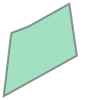

In [101]:
wkt_poly="""Polygon ((552076.7757061361335218 4124658.43376859556883574, 552077.55741135939024389 4124662.18595366738736629, 552092.0971285121049732 4124667.6578902299515903, 552127.74288669310044497 4124687.51320290099829435, 552134.30921056855004281 4124642.33064099634066224, 552070.67840539466124028 4124606.99756490439176559, 552076.7757061361335218 4124658.43376859556883574))
"""
from shapely import geometry
from shapely import wkt
dir(wkt)
wkt.loads(wkt_poly)